In [56]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from math import pi
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


## Importação de Dados do Big Query

### Autenticação

In [2]:
#Importando Dados do Big Query
from google.cloud import bigquery
from google.api_core import exceptions

key_path = "keyfile.json"

try:
    client = bigquery.Client.from_service_account_json(key_path)

    print(f"Autenticação bem-sucedida com o projeto: {client.project}")

except FileNotFoundError:
    print(f"ERRO: O arquivo de chave não foi encontrado no caminho especificado: {key_path}")
    print("Verifique se o caminho está correto.")
    exit()
except Exception as e:
    print(f"Ocorreu um erro inesperado durante a autenticação: {e}")
    exit()


Autenticação bem-sucedida com o projeto: viitra-redu


### Consulta

In [3]:
data_inicio = '2020-01-01'
data_fim = '2021-12-31'

sql_query = f"""
select
     eng.cliente
    ,eng.user_id
    ,eng.environment_id
    ,eng.course_id
    ,eng.space_id
    ,eng.subject_id
    ,eng.lecture_id
    ,eng.NivelAgregacao
    ,eng.user_name
    ,eng.environment_name
    ,eng.course_name
    ,eng.space_name
    ,eng.subject_name
    ,eng.lecture_name
    ,eng.period_start_date
    ,eng.period_end_date
    ,eng.postsAmount
    ,eng.postRepliesAmount
    ,eng.helpRequestsAmount
    ,eng.helpRequestRepliesAmount
    ,eng.performance_rate
from analytics.fn_engajamento(
  DATE('{data_inicio}'),
  DATE('{data_fim}'),
  TRUE,'redu-digital',
  73,
  NULL,
  NULL,
  NULL,
  NULL,'SPA', 'QUARTER'
) as eng
inner join (
    select 
        uea.user_id
        ,uea.cliente 
    from replicas.user_environment_associations uea 
    where uea.role not in ('teacher', 'tutor', 'environment_admin')
) as filtro on filtro.cliente = eng.cliente and filtro.user_id = eng.user_id
"""
try:
    dataframe = client.query(sql_query).to_dataframe()
    print(dataframe.head())
except exceptions.Forbidden as e:
    print(f"ERRO DE PERMISSÃO: {e}")
    print("A autenticação funcionou, mas a conta de serviço não tem permissão para acessar os dados.")
    print("Verifique os papéis de IAM (ex: 'BigQuery User') no Google Cloud Console.")

c:\Users\Matheus Monte\Documents\Classificador\env\Lib\site-packages\google\cloud\bigquery\table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


        cliente  user_id  environment_id  course_id  space_id  subject_id  \
0  redu-digital      496              73        155       534        <NA>   
1  redu-digital      455              73        155       534        <NA>   
2  redu-digital      455              73        155       534        <NA>   
3  redu-digital      455              73        155       534        <NA>   
4  redu-digital      455              73        155       534        <NA>   

   lecture_id NivelAgregacao                                user_name  \
0        <NA>            SPA  IZABELYTA GUERRA PASCOAL VIEIRA DE MELO   
1        <NA>            SPA                    ELIEZIO JOSE DA SILVA   
2        <NA>            SPA                    ELIEZIO JOSE DA SILVA   
3        <NA>            SPA                    ELIEZIO JOSE DA SILVA   
4        <NA>            SPA                    ELIEZIO JOSE DA SILVA   

  environment_name  ...                                 space_name  \
0         SENAC-PE  ...  4. 

## Análise Exploratória

In [4]:
print(dataframe.head())
dataframe.info()

        cliente  user_id  environment_id  course_id  space_id  subject_id  \
0  redu-digital      496              73        155       534        <NA>   
1  redu-digital      455              73        155       534        <NA>   
2  redu-digital      455              73        155       534        <NA>   
3  redu-digital      455              73        155       534        <NA>   
4  redu-digital      455              73        155       534        <NA>   

   lecture_id NivelAgregacao                                user_name  \
0        <NA>            SPA  IZABELYTA GUERRA PASCOAL VIEIRA DE MELO   
1        <NA>            SPA                    ELIEZIO JOSE DA SILVA   
2        <NA>            SPA                    ELIEZIO JOSE DA SILVA   
3        <NA>            SPA                    ELIEZIO JOSE DA SILVA   
4        <NA>            SPA                    ELIEZIO JOSE DA SILVA   

  environment_name  ...                                 space_name  \
0         SENAC-PE  ...  4. 

In [5]:
dataframe.describe()

,user_id,environment_id,course_id,space_id,subject_id,lecture_id,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,13856.0,13856.0,13856.0,13856.0,0.0,0.0,13856.0,13856.0,13856.0,13856.0,13856.000000
mean,1246.944573,73.0,155.0,330.0,<NA>,<NA>,0.262341,0.023456,0.001371,0.002309,0.076483
std,2534.517551,0.0,0.0,198.711725,<NA>,<NA>,1.378585,0.294957,0.040721,0.067926,0.232054
min,448.0,73.0,155.0,120.0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
25%,549.0,73.0,155.0,137.25,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
50%,668.0,73.0,155.0,333.0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
75%,790.0,73.0,155.0,525.75,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
max,19033.0,73.0,155.0,534.0,<NA>,<NA>,27.0,12.0,2.0,4.0,1.000000


In [6]:
valores_set = dataframe.iloc[:, 16:]

In [7]:
valores_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  Int64  
 1   postRepliesAmount         13856 non-null  Int64  
 2   helpRequestsAmount        13856 non-null  Int64  
 3   helpRequestRepliesAmount  13856 non-null  Int64  
 4   performance_rate          13856 non-null  float64
dtypes: Int64(4), float64(1)
memory usage: 595.5 KB


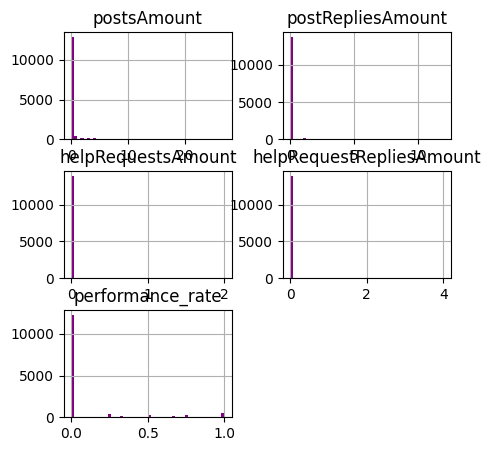

In [8]:
valores_set.hist(bins=50, figsize=(5, 5), color='purple')
plt.show()

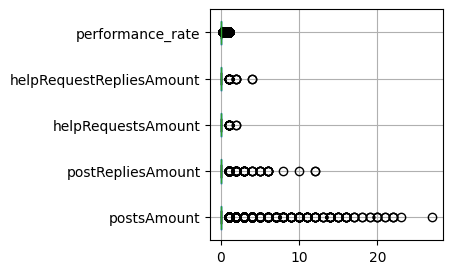

In [9]:
valores_set.boxplot(vert=False, figsize=(3, 3))
plt.show()

### Pré-Processamento

In [10]:
train_set = valores_set.copy()
train_set.shape

(13856, 5)

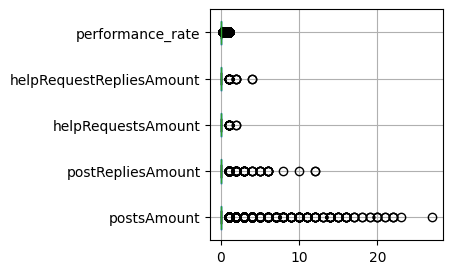

In [11]:
train_set.boxplot(vert=False , figsize=(3,3))
plt.show()

In [12]:
train_set.info()
train_set.describe()
train_set.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  Int64  
 1   postRepliesAmount         13856 non-null  Int64  
 2   helpRequestsAmount        13856 non-null  Int64  
 3   helpRequestRepliesAmount  13856 non-null  Int64  
 4   performance_rate          13856 non-null  float64
dtypes: Int64(4), float64(1)
memory usage: 595.5 KB


,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
0,0,0,0,0,0.333333
1,0,0,0,0,0.000000
2,0,0,0,0,0.000000
3,0,0,0,0,0.000000
4,0,0,0,0,0.000000


#### Tratando Valores Faltantes

In [13]:
inputer = KNNImputer(n_neighbors=5)
train_set_inpute = inputer.fit_transform(train_set)

In [14]:
# train_set_inpute = inputer.transform(train_set)

In [15]:
train_set_inputado = pd.DataFrame(
    train_set_inpute,
    columns=train_set.columns,
    index=train_set.index
)
train_set = train_set_inputado.copy()
train_set.info()
train_set.describe()
print(train_set.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  float64
 1   postRepliesAmount         13856 non-null  float64
 2   helpRequestsAmount        13856 non-null  float64
 3   helpRequestRepliesAmount  13856 non-null  float64
 4   performance_rate          13856 non-null  float64
dtypes: float64(5)
memory usage: 541.4 KB
Index(['postsAmount', 'postRepliesAmount', 'helpRequestsAmount',
       'helpRequestRepliesAmount', 'performance_rate'],
      dtype='object')


In [16]:
# train_set = train_set_inputado.copy()
# train_set.info()

In [17]:
# train_set.describe()

In [18]:
# print(train_set.columns)

#### Tratando Outliers

In [19]:
df_features = train_set.copy()
# Lista de colunas assimétricas
colunas_para_log = ['postsAmount', 'postRepliesAmount', 'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate'] # Exemplo

for col in colunas_para_log:
    # nova coluna para não sobrescrever a original
    df_features[f'{col}_log'] = np.log1p(train_set[col])

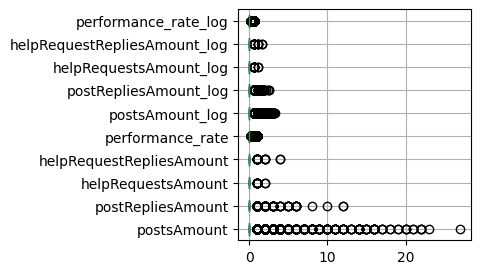

In [20]:
df_features.boxplot(vert=False, figsize= (3,3))
plt.show()

In [21]:
# Encontrar todas as colunas que terminam com '_log'
log_cols = [col for col in df_features.columns if col.endswith('_log')]

# A partir das colunas de log, deduzir os nomes das colunas originais que as geraram
original_cols_to_drop = [col.replace('_log', '') for col in log_cols]

# A lista final de colunas é composta por TODAS as colunas, EXCETO as originais que foram transformadas
final_cols_to_keep = [col for col in df_features.columns if col not in original_cols_to_drop]


# --- Passo 2: Criar o DataFrame Final ---
train_set_final = df_features[final_cols_to_keep]
train_set_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   postsAmount_log               13856 non-null  float64
 1   postRepliesAmount_log         13856 non-null  float64
 2   helpRequestsAmount_log        13856 non-null  float64
 3   helpRequestRepliesAmount_log  13856 non-null  float64
 4   performance_rate_log          13856 non-null  float64
dtypes: float64(5)
memory usage: 541.4 KB


In [22]:
# train_set_final.info()

#### Escalonamento das Features

In [23]:
scaler = MinMaxScaler()
#feature_range=(-1, 1)
train_set_scaled_np = scaler.fit_transform(train_set_final)

In [24]:
train_set_scaled = pd.DataFrame(
train_set_scaled_np,
    columns=train_set_final.columns,
    index=train_set_final.index
)

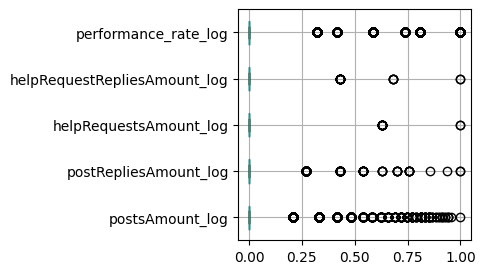

In [25]:
train_set_final = train_set_scaled.copy()
train_set_final.boxplot(vert=False, figsize= (3,3))
plt.show()

In [26]:
# train_set_final.boxplot(vert=False)
# plt.show()

## Treinamento Não-Supervisionado

#### Encontrando melhores parâmetros para o Kmeans

In [27]:
# faixas de k para testar
k_range = range(2, 11)  # começa em 2 (não faz sentido silhouette com k=1)

# métricas
wcss = []
silhouette = []
calinski = []
davies = []
bic = []

for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(train_set_final)

    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(train_set_final, labels))
    calinski.append(calinski_harabasz_score(train_set_final, labels))
    davies.append(davies_bouldin_score(train_set_final, labels))

    # BIC com GaussianMixture
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(train_set_final)
    bic.append(gmm.bic(train_set_final))

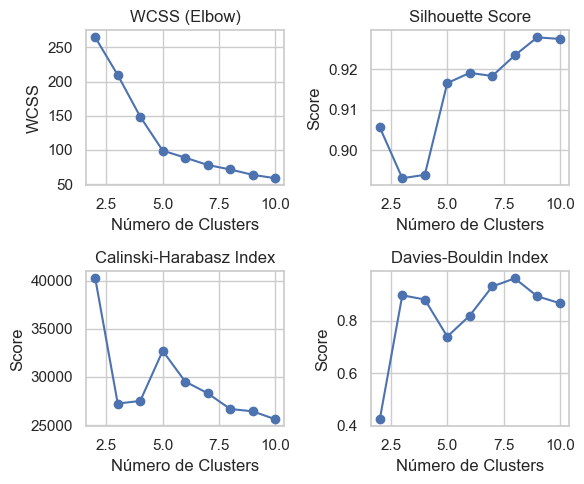

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 5))

# WCSS (cotovelo)
plt.subplot(2, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('WCSS (Elbow)')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

# Silhouette
plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Calinski-Harabasz
plt.subplot(2, 2, 3)
plt.plot(k_range, calinski, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Davies-Bouldin (quanto menor, melhor)
plt.subplot(2, 2, 4)
plt.plot(k_range, davies, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# BIC separado (opcional)
# plt.figure()
# plt.plot(k_range, bic, marker='o')
# plt.title('BIC - Gaussian Mixture')
# plt.xlabel('Número de Clusters')
# plt.ylabel('BIC')
# plt.show()


#### Treinamento 

In [29]:
# Treinamento do K-Means
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(train_set_final)

In [30]:
tabela_contagem = pd.Series(y_kmeans).value_counts()

# Exibe a tabela final
print("Quantidade de itens por cluster:")
print(tabela_contagem)

Quantidade de itens por cluster:
0    12210
2      686
3      580
1      380
Name: count, dtype: int64


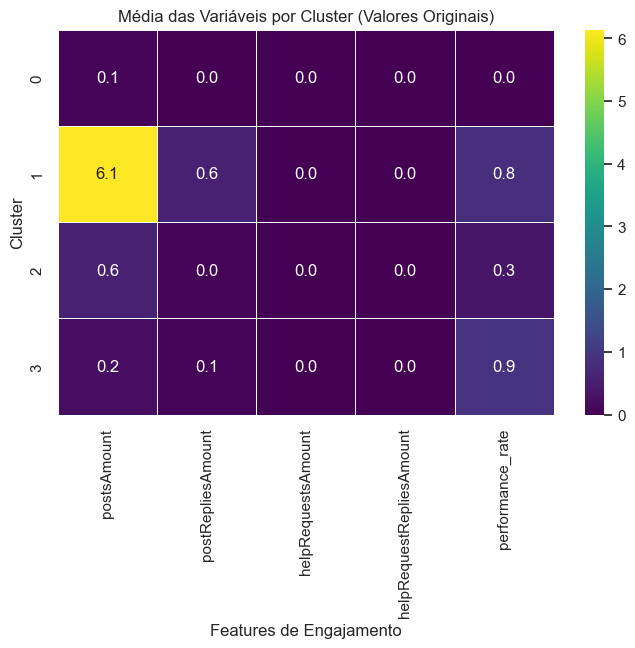

In [31]:
train_set['cluster'] = y_kmeans

# Calcular as médias por cluster
cluster_means = train_set.groupby('cluster').mean()

# Renomear colunas para o plot (removendo o sufixo '_log')
cluster_means_para_plotar = cluster_means.rename(columns=lambda c: c.replace('_log', ''))

# Passo 3: Plotar o Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    cluster_means_para_plotar,
    annot=True,
    fmt='.1f',
    cmap='viridis',
    linewidths=.5
)
plt.title('Média das Variáveis por Cluster (Valores Originais)', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.xlabel('Features de Engajamento', fontsize=12)
plt.show()

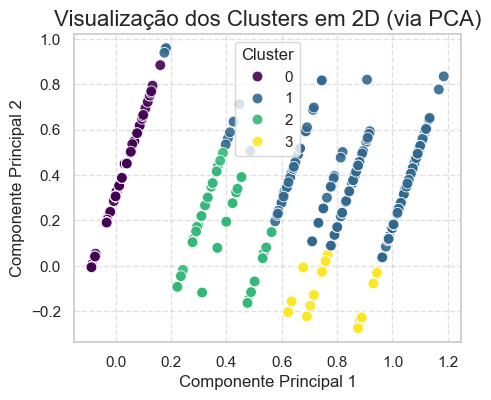

In [32]:
# Passo 1: Reduzir a dimensionalidade dos dados ESCALONADOS para 2D com PCA
pca = PCA(n_components=2)
dados_pca = pca.fit_transform(train_set_final)

# Passo 2: Criar um DataFrame para a visualização
df_pca = pd.DataFrame({
    'PCA1': dados_pca[:, 0],
    'PCA2': dados_pca[:, 1],
    'Cluster': y_kmeans
})

# Passo 3: Plotar o gráfico de dispersão
plt.figure(figsize=(5, 4))
sns.scatterplot(
    data=df_pca,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    s=60,
    alpha=0.9
)

plt.title('Visualização dos Clusters em 2D (via PCA)', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

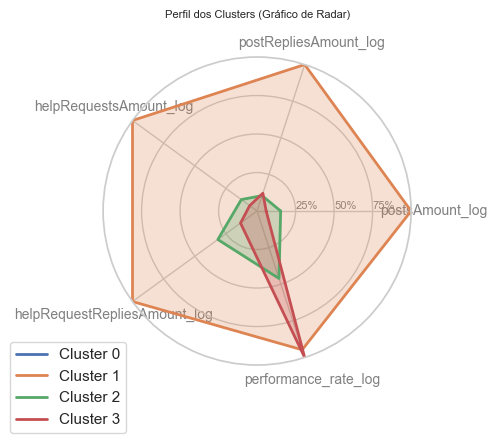

In [33]:
# Passo 1: Unir os dados originais e os clusters
df_analise = train_set_final.copy()
df_analise['Cluster'] = y_kmeans

# Passo 2: Calcular as médias de cada feature para cada cluster
centroids = df_analise.groupby('Cluster').mean()

# Passo 3: Escalonar os centroides para que fiquem na mesma escala (0 a 1) para o plot
scaler_radar = MinMaxScaler()
centroids_scaled = pd.DataFrame(scaler_radar.fit_transform(centroids), index=centroids.index, columns=centroids.columns)

# Passo 4: Código de plotagem do Gráfico de Radar
labels = centroids_scaled.columns
num_vars = len(labels)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))
plt.xticks(angles[:-1], labels, color='grey', size=10)
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=8)
plt.ylim(0, 1)

# Plotar a linha de cada cluster
for i in range(len(centroids_scaled)):
    values = centroids_scaled.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

plt.title('Perfil dos Clusters (Gráfico de Radar)', size=8, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

--- Regras da Árvore de Decisão ---
|--- performance_rate_log <= 0.16
|   |--- postsAmount_log <= 0.86
|   |   |--- class: 0
|   |--- postsAmount_log >  0.86
|   |   |--- postRepliesAmount_log <= 0.21
|   |   |   |--- class: 0
|   |   |--- postRepliesAmount_log >  0.21
|   |   |   |--- class: 1
|--- performance_rate_log >  0.16
|   |--- performance_rate_log <= 0.66
|   |   |--- postsAmount_log <= 0.56
|   |   |   |--- class: 2
|   |   |--- postsAmount_log >  0.56
|   |   |   |--- class: 1
|   |--- performance_rate_log >  0.66
|   |   |--- postsAmount_log <= 0.27
|   |   |   |--- class: 3
|   |   |--- postsAmount_log >  0.27
|   |   |   |--- class: 1


--- Visualização da Árvore ---


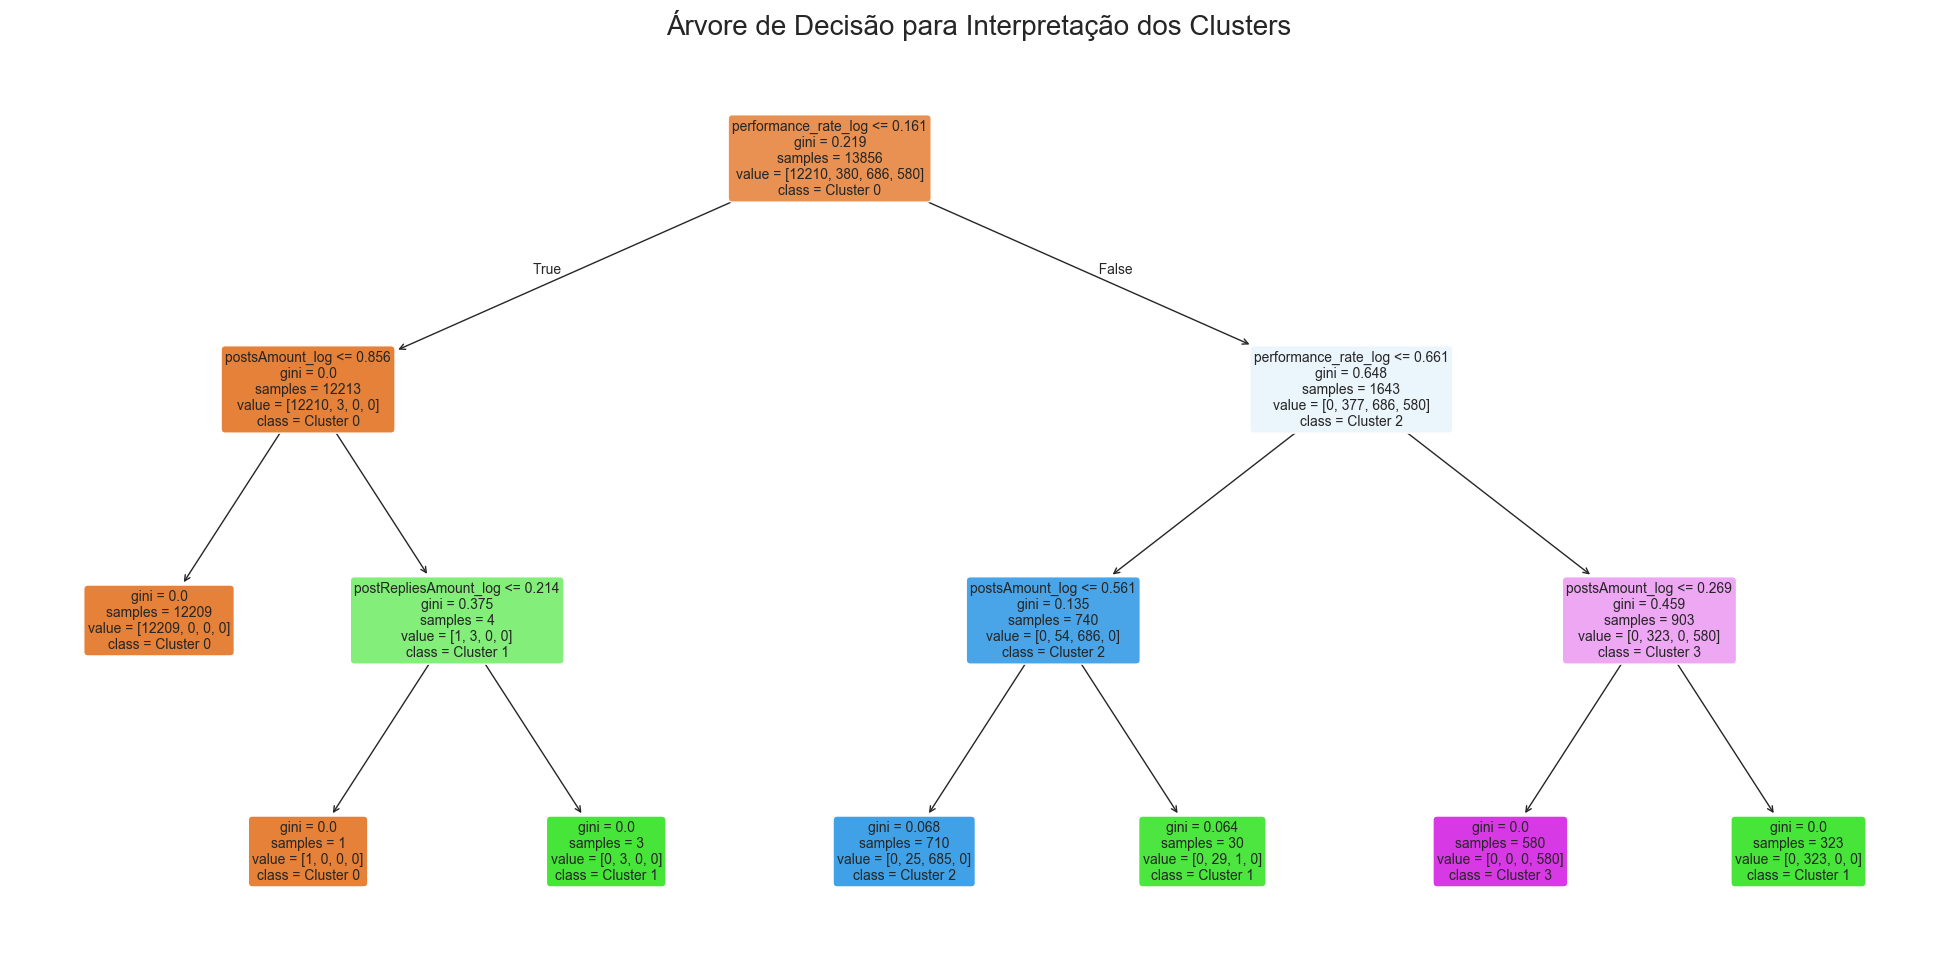

In [34]:
# --- 2. TREINAR A ÁRVORE DE DECISÃO ---

X = train_set_final
y = y_kmeans

# Inicializar o classificador.
arvore_de_decisao = DecisionTreeClassifier(max_depth=3, random_state=42)

# Treinar a árvore para aprender a mapear as features para os clusters
arvore_de_decisao.fit(X, y)


# Extrair as regras como texto 
print("--- Regras da Árvore de Decisão ---")
nomes_features = X.columns.tolist()
regras_texto = export_text(arvore_de_decisao, feature_names=nomes_features)
print(regras_texto)


#  Visualizar a árvore de decisão 
print("\n--- Visualização da Árvore ---")
# Nomes das classes para a legenda do gráfico
nomes_classes = [f'Cluster {i}' for i in sorted(np.unique(y))]

plt.figure(figsize=(25, 12))
plot_tree(
    arvore_de_decisao,
    feature_names=nomes_features,
    class_names=nomes_classes,
    filled=True,  
    rounded=True, 
    fontsize=10
)
plt.title("Árvore de Decisão para Interpretação dos Clusters", fontsize=20)
plt.show()

#### Adicionando Labels aos Clusters

In [35]:

centroids = train_set.groupby('cluster').mean()

print("--- Médias das Variáveis Originais por Cluster ---")
print(centroids)
print("-" * 50)

# Passo 2: Ranquear os centroides para cada métrica
# ascending=False significa que o maior valor recebe o rank 1 (melhor)
centroids['rank_posts'] = centroids['postsAmount'].rank(method='first', ascending=False)
centroids['rank_performance'] = centroids['performance_rate'].rank(method='first', ascending=False)

# Criar scores combinados para facilitar a identificação
# Score Geral: soma dos ranks (quanto menor, melhor)
centroids['score_geral'] = centroids['rank_posts'] + centroids['rank_performance']

print("\n--- Centroides com Ranks e Scores ---")
print(centroids)
print("-" * 50)


# Passo 3: Aplicar as regras de negócio para identificar cada cluster
mapa_de_labels = {}

# "Engajamento excelente": Melhor rank em posts E melhor rank em performance.
# Portanto, terá o menor 'score_geral'.
id_excelente = centroids['score_geral'].idxmin()
mapa_de_labels[id_excelente] = "Engajamento excelente"

# "Não interagem": Pior rank em posts E pior rank em performance.
# Portanto, terá o maior 'score_geral'.
id_nao_interagem = centroids['score_geral'].idxmax()
mapa_de_labels[id_nao_interagem] = "Não interagem"

# Para os dois restantes, analisamos os ranks individuais
indices_restantes = [c for c in centroids.index if c not in mapa_de_labels]

cluster_restante_1 = centroids.loc[indices_restantes[0]]
cluster_restante_2 = centroids.loc[indices_restantes[1]]

# "Engajamento consistente": Rank de performance é MELHOR (menor) que o rank de posts.
# "Desempenho crítico": Rank de posts é MELHOR (menor) que o rank de performance.
if cluster_restante_1['rank_performance'] < cluster_restante_1['rank_posts']:
    mapa_de_labels[indices_restantes[0]] = "Engajamento consistente"
    mapa_de_labels[indices_restantes[1]] = "Desempenho crítico"
else:
    mapa_de_labels[indices_restantes[1]] = "Engajamento consistente"
    mapa_de_labels[indices_restantes[0]] = "Desempenho crítico"


print("\n--- Mapa de Labels Gerado Automaticamente ---")
# Ordena o dicionário pela chave (número do cluster) para facilitar a leitura
mapa_de_labels = dict(sorted(mapa_de_labels.items()))
print(mapa_de_labels)


# Passo 4: Aplicar o mapa gerado para criar a coluna final
train_set['categoria_interacao'] = train_set['cluster'].map(mapa_de_labels)

print("\n--- Contagem final das novas categorias ---")
print(train_set['categoria_interacao'].value_counts())

--- Médias das Variáveis Originais por Cluster ---
         postsAmount  postRepliesAmount  helpRequestsAmount  \
cluster                                                       
0           0.066093           0.004013            0.000737   
1           6.139474           0.557895            0.018421   
2           0.558309           0.048105            0.002915   
3           0.193103           0.053448            0.001724   

         helpRequestRepliesAmount  performance_rate  
cluster                                              
0                        0.001392          0.000000  
1                        0.021053          0.828728  
2                        0.007289          0.340500  
3                        0.003448          0.881466  
--------------------------------------------------

--- Centroides com Ranks e Scores ---
         postsAmount  postRepliesAmount  helpRequestsAmount  \
cluster                                                       
0           0.066093          

In [36]:
print(train_set['categoria_interacao'].value_counts())

categoria_interacao
Não interagem              12210
Desempenho crítico           686
Engajamento consistente      580
Engajamento excelente        380
Name: count, dtype: int64


In [37]:
dataset_clss = train_set.copy()
dataset_clss.head()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
0,0.0,0.0,0.0,0.0,0.333333,2,Desempenho crítico
1,0.0,0.0,0.0,0.0,0.000000,0,Não interagem
2,0.0,0.0,0.0,0.0,0.000000,0,Não interagem
3,0.0,0.0,0.0,0.0,0.000000,0,Não interagem
4,0.0,0.0,0.0,0.0,0.000000,0,Não interagem


In [38]:
dataset_clss.tail()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
13851,0.0,0.0,0.0,0.0,0.0,0,Não interagem
13852,0.0,0.0,0.0,0.0,0.0,0,Não interagem
13853,0.0,0.0,0.0,0.0,0.0,0,Não interagem
13854,0.0,0.0,0.0,0.0,0.0,0,Não interagem
13855,0.0,0.0,0.0,0.0,0.0,0,Não interagem


In [39]:
dataset_clss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  float64
 1   postRepliesAmount         13856 non-null  float64
 2   helpRequestsAmount        13856 non-null  float64
 3   helpRequestRepliesAmount  13856 non-null  float64
 4   performance_rate          13856 non-null  float64
 5   cluster                   13856 non-null  int32  
 6   categoria_interacao       13856 non-null  object 
dtypes: float64(5), int32(1), object(1)
memory usage: 703.8+ KB


In [40]:
dataframe['categoria_engajamento'] = dataset_clss['categoria_interacao']

In [41]:
dataframe.head()

,cliente,user_id,environment_id,course_id,space_id,subject_id,lecture_id,NivelAgregacao,user_name,environment_name,...,subject_name,lecture_name,period_start_date,period_end_date,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,categoria_engajamento
0,redu-digital,496,73,155,534,<NA>,<NA>,SPA,IZABELYTA GUERRA PASCOAL VIEIRA DE MELO,SENAC-PE,...,None,None,2021-10-01,2021-12-31,0,0,0,0,0.333333,Desempenho crítico
1,redu-digital,455,73,155,534,<NA>,<NA>,SPA,ELIEZIO JOSE DA SILVA,SENAC-PE,...,None,None,2020-07-01,2020-09-30,0,0,0,0,0.000000,Não interagem
2,redu-digital,455,73,155,534,<NA>,<NA>,SPA,ELIEZIO JOSE DA SILVA,SENAC-PE,...,None,None,2020-07-01,2020-09-30,0,0,0,0,0.000000,Não interagem
3,redu-digital,455,73,155,534,<NA>,<NA>,SPA,ELIEZIO JOSE DA SILVA,SENAC-PE,...,None,None,2020-10-01,2020-12-31,0,0,0,0,0.000000,Não interagem
4,redu-digital,455,73,155,534,<NA>,<NA>,SPA,ELIEZIO JOSE DA SILVA,SENAC-PE,...,None,None,2020-10-01,2020-12-31,0,0,0,0,0.000000,Não interagem


In [42]:
dataframe['data_inicio'] = pd.to_datetime(data_inicio).date()
dataframe['data_fim'] = pd.to_datetime(data_fim).date()


# Passo 2: Adicionar a data de hoje como data da classificação
# A função date.today() captura a data atual em que o código é executado.
dataframe['data_classificacao'] = date.today()

In [43]:
dataframe.head()

,cliente,user_id,environment_id,course_id,space_id,subject_id,lecture_id,NivelAgregacao,user_name,environment_name,...,period_end_date,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,categoria_engajamento,data_inicio,data_fim,data_classificacao
0,redu-digital,496,73,155,534,<NA>,<NA>,SPA,IZABELYTA GUERRA PASCOAL VIEIRA DE MELO,SENAC-PE,...,2021-12-31,0,0,0,0,0.333333,Desempenho crítico,2020-01-01,2021-12-31,2025-09-01
1,redu-digital,455,73,155,534,<NA>,<NA>,SPA,ELIEZIO JOSE DA SILVA,SENAC-PE,...,2020-09-30,0,0,0,0,0.000000,Não interagem,2020-01-01,2021-12-31,2025-09-01
2,redu-digital,455,73,155,534,<NA>,<NA>,SPA,ELIEZIO JOSE DA SILVA,SENAC-PE,...,2020-09-30,0,0,0,0,0.000000,Não interagem,2020-01-01,2021-12-31,2025-09-01
3,redu-digital,455,73,155,534,<NA>,<NA>,SPA,ELIEZIO JOSE DA SILVA,SENAC-PE,...,2020-12-31,0,0,0,0,0.000000,Não interagem,2020-01-01,2021-12-31,2025-09-01
4,redu-digital,455,73,155,534,<NA>,<NA>,SPA,ELIEZIO JOSE DA SILVA,SENAC-PE,...,2020-12-31,0,0,0,0,0.000000,Não interagem,2020-01-01,2021-12-31,2025-09-01


In [44]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cliente                   13856 non-null  object 
 1   user_id                   13856 non-null  Int64  
 2   environment_id            13856 non-null  Int64  
 3   course_id                 13856 non-null  Int64  
 4   space_id                  13856 non-null  Int64  
 5   subject_id                0 non-null      Int64  
 6   lecture_id                0 non-null      Int64  
 7   NivelAgregacao            13856 non-null  object 
 8   user_name                 13856 non-null  object 
 9   environment_name          13856 non-null  object 
 10  course_name               13856 non-null  object 
 11  space_name                13856 non-null  object 
 12  subject_name              0 non-null      object 
 13  lecture_name              0 non-null      object 
 14  period

In [45]:
# # Define o nome completo da tabela de destino
# table_id = "viitra-redu.analytics.cubo_engajamento"

# # Prepara o DataFrame para envio
# df_to_load = dataframe.copy()
# df_to_load = df_to_load.rename(columns={
#     'categoria_interacao': 'categoria_engajamento',
#     'data_inicio_consulta': 'data_inicio',
#     'data_fim_consulta': 'data_fim'
# })

# # Converte as colunas de data para o tipo datetime do pandas, a forma mais robusta
# date_columns = ['data_inicio', 'data_fim', 'data_classificacao']
# for col in date_columns:
#     if col in df_to_load.columns:
#         df_to_load[col] = pd.to_datetime(df_to_load[col])

# # Garante que o DataFrame tenha apenas as colunas da tabela de destino
# schema_columns = [
#     'cliente', 'user_id', 'environment_id', 'course_id', 'space_id', 
#     'subject_id', 'lecture_id', 'NivelAgregacao', 'user_name', 
#     'environment_name', 'course_name', 'space_name', 'subject_name', 
#     'lecture_name', 'postsAmount', 'postRepliesAmount', 
#     'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate', 
#     'categoria_engajamento', 'data_inicio', 'data_fim', 'data_classificacao'
# ]
# df_to_load = df_to_load[schema_columns]

# # Configura o job para adicionar os dados (append)
# job_config = bigquery.LoadJobConfig(write_disposition="WRITE_APPEND")

# print(f"Iniciando o carregamento de {len(df_to_load)} registros para a tabela {table_id}...")

# try:
#     # Envia o DataFrame para o BigQuery e aguarda a conclusão
#     load_job = client.load_table_from_dataframe(
#         df_to_load, table_id, job_config=job_config
#     )
#     load_job.result()
#     print("Carregamento concluído com sucesso!")
#     print(f"Foram carregadas {load_job.output_rows} linhas.")

# except Exception as e:
#     print(f"Ocorreu um erro durante o carregamento: {e}")
#     if 'load_job' in locals() and load_job.errors:
#         print("Detalhes do erro do BigQuery:", load_job.errors)

# # Executa uma consulta de verificação no BigQuery
# print("\nVerificação dos dados inseridos hoje no BigQuery:")
# query = f"""
#     SELECT data_classificacao, COUNT(1) as total_registros
#     FROM `{table_id}`
#     WHERE data_classificacao = CURRENT_DATE('America/Sao_Paulo')
#     GROUP BY 1
# """
# results_df = client.query(query).to_dataframe()
# print(results_df)

# Treinamento Supervisionado

In [46]:
#Treinamento supervisionado 

In [47]:
df = dataframe.copy()

In [48]:
features = ['postsAmount', 'postRepliesAmount', 'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate']
target = 'categoria_engajamento'

X = df[features]
y = df[target]

# Primeira divisão: 80% para treino/validação e 20% para teste final.
X_temp, X_teste, y_temp, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Segunda divisão: divide os 80% em 60% para treino e 20% para validação.
X_treino, X_validacao, y_treino, y_validacao = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Passo 3: Dados divididos em conjuntos de treino, validação e teste.")
print(f"  - Treino: {X_treino.shape[0]} amostras")
print(f"  - Validação: {X_validacao.shape[0]} amostras")
print(f"  - Teste: {X_teste.shape[0]} amostras")

Passo 3: Dados divididos em conjuntos de treino, validação e teste.
  - Treino: 8313 amostras
  - Validação: 2771 amostras
  - Teste: 2772 amostras


In [49]:
features = ['postsAmount', 'postRepliesAmount', 'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate']
target = 'categoria_engajamento'

X = df[features]
y = df[target]

# --- Divisão Corrigida ---

# 1. Primeira Divisão: Separa 20% para o conjunto de TESTE final.
# Os 80% restantes são temporariamente chamados de 'X_temp' e 'y_temp'.
X_temp, X_teste, y_temp, y_teste = train_test_split(
    X, y, 
    test_size=0.2,        # 20% para teste
    random_state=42, 
    stratify=y
)

# 2. Segunda Divisão: Divide os 80% restantes em TREINO e VALIDAÇÃO.
# O conjunto de validação terá 25% de X_temp (0.25 * 0.80 = 20% do total).
X_treino, X_validacao, y_treino, y_validacao = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,       # 25% de 80% = 20% do total para validação
    random_state=42, 
    stratify=y_temp
)

In [50]:
le = LabelEncoder()
y_treino_encoded = le.fit_transform(y_treino)
y_validacao_encoded = le.transform(y_validacao)
y_teste_encoded = le.transform(y_teste)

In [51]:
# Definição dos modelos a serem comparados
model_baseline = RandomForestClassifier(random_state=42, n_jobs=-1)
model_balanced = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Estratégia de validação cruzada (será aplicada no conjunto de TREINO)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Execução e cálculo dos scores
cv_scores_baseline = cross_val_score(model_baseline, X_treino, y_treino_encoded, cv=cv_strategy, scoring='f1_weighted')
cv_scores_balanced = cross_val_score(model_balanced, X_treino, y_treino_encoded, cv=cv_strategy, scoring='f1_weighted')

# Apresentação dos resultados da Validação Cruzada
print("\n================== RESULTADOS DA VALIDAÇÃO CRUZADA ==================")
print(f"Métrica: F1-Score Ponderado (média de {cv_strategy.get_n_splits()} folds)")
print("-" * 65)
print(f"Modelo Baseline                  : {cv_scores_baseline.mean():.4f} (+/- {cv_scores_baseline.std():.4f})")
print(f"Modelo com class_weight='balanced' : {cv_scores_balanced.mean():.4f} (+/- {cv_scores_balanced.std():.4f})")
print("=" * 65)
print("\nConclusão: O modelo balanceado é o escolhido para o teste final.")



================== RESULTADOS DA VALIDAÇÃO CRUZADA ==================
Métrica: F1-Score Ponderado (média de 5 folds)
-----------------------------------------------------------------
Modelo Baseline                  : 0.9995 (+/- 0.0007)
Modelo com class_weight='balanced' : 0.9995 (+/- 0.0007)

Conclusão: O modelo balanceado é o escolhido para o teste final.


In [52]:
print("\nIniciando Passo 6: Treinamento do modelo final e avaliação no conjunto de teste...")

# Treina o modelo escolhido (balanceado) no conjunto de treino completo
model_balanced.fit(X_treino, y_treino_encoded)

# Faz a previsão no conjunto de teste (dados nunca vistos pelo modelo)
y_pred_teste = model_balanced.predict(X_teste)

# Gera e exibe o relatório de classificação final
print("\n=========== RELATÓRIO DE CLASSIFICAÇÃO FINAL (TESTE) ===========")
report = classification_report(y_teste_encoded, y_pred_teste, target_names=le.classes_)
print(report)
print("=" * 65)


Iniciando Passo 6: Treinamento do modelo final e avaliação no conjunto de teste...

=========== RELATÓRIO DE CLASSIFICAÇÃO FINAL (TESTE) ===========
                         precision    recall  f1-score   support

     Desempenho crítico       1.00      1.00      1.00       137
Engajamento consistente       1.00      1.00      1.00       116
  Engajamento excelente       1.00      1.00      1.00        76
          Não interagem       1.00      1.00      1.00      2443

               accuracy                           1.00      2772
              macro avg       1.00      1.00      1.00      2772
           weighted avg       1.00      1.00      1.00      2772



In [53]:
# NOVO PASSO: Treinar o modelo sem a feature 'performance_rate' para teste
features_sem_vazamento = ['postsAmount', 'postRepliesAmount', 'helpRequestsAmount', 'helpRequestRepliesAmount']

X_treino_sem_vazamento = X_treino[features_sem_vazamento]
X_teste_sem_vazamento = X_teste[features_sem_vazamento]

# Usar o mesmo modelo balanceado
model_teste_vazamento = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Treinar e avaliar novamente
model_teste_vazamento.fit(X_treino_sem_vazamento, y_treino_encoded)
y_pred_teste_sem_vazamento = model_teste_vazamento.predict(X_teste_sem_vazamento)

print("\n=========== RELATÓRIO DE CLASSIFICAÇÃO SEM 'performance_rate' ===========")
report_sem_vazamento = classification_report(y_teste_encoded, y_pred_teste_sem_vazamento, target_names=le.classes_)
print(report_sem_vazamento)
print("=" * 65)


=========== RELATÓRIO DE CLASSIFICAÇÃO SEM 'performance_rate' ===========
                         precision    recall  f1-score   support

     Desempenho crítico       0.20      0.01      0.01       137
Engajamento consistente       0.30      0.19      0.23       116
  Engajamento excelente       0.60      1.00      0.75        76
          Não interagem       0.93      0.98      0.95      2443

               accuracy                           0.90      2772
              macro avg       0.51      0.54      0.49      2772
           weighted avg       0.86      0.90      0.87      2772



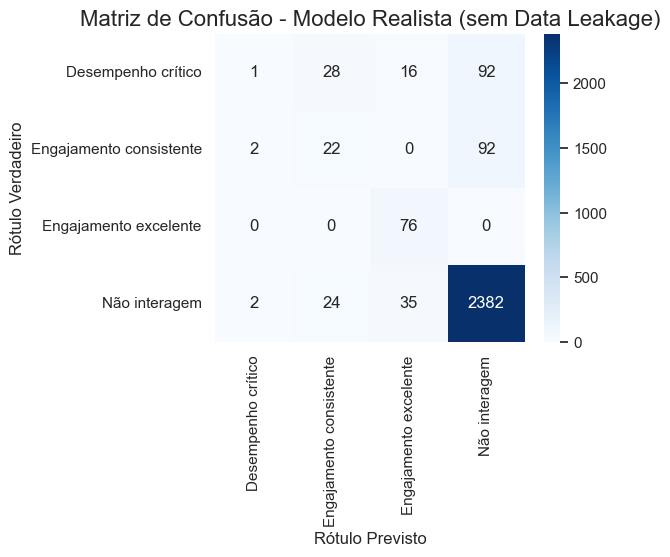

In [55]:
# 1. Calcular a Matriz de Confusão
cm = confusion_matrix(y_teste_encoded, y_pred_teste_sem_vazamento)

# 2. Visualizar a Matriz de Confusão com Seaborn e Matplotlib
plt.figure(figsize=(5, 4))
sns.heatmap(cm, 
            annot=True,         # Anotar os números em cada célula
            fmt='d',            # Formatar os números como inteiros
            cmap='Blues',       # Esquema de cores
            xticklabels=le.classes_, 
            yticklabels=le.classes_)

plt.title('Matriz de Confusão - Modelo Realista (sem Data Leakage)', fontsize=16)
plt.ylabel('Rótulo Verdadeiro', fontsize=12)
plt.xlabel('Rótulo Previsto', fontsize=12)
plt.show()

In [63]:
features_sem_vazamento = [
    'postsAmount',
    'postRepliesAmount',
    'helpRequestsAmount',
    'helpRequestRepliesAmount'
]
X_treino_safe = X_treino[features_sem_vazamento]


# 1. Definir o espaço de busca dos hiperparâmetros
param_dist = {
    'n_estimators': randint(100, 800),              # Número de árvores
    'max_depth': randint(5, 40),                    # Profundidade máxima (valores menores para evitar overfitting)
    'min_samples_leaf': randint(2, 20),             # Mínimo de amostras por folha (importante para regularização)
    'min_samples_split': randint(5, 30),            # Mínimo de amostras para dividir um nó
    'max_features': ['sqrt', 'log2']                # Número de features a considerar
}

# 2. Instanciar o modelo base que será otimizado
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state=42)

# 3. Configurar a busca aleatória (Randomized Search)
# n_iter=50 significa que 50 combinações de parâmetros serão testadas.
random_search = RandomizedSearchCV(
    estimator=rf_balanced,
    param_distributions=param_dist,
    n_iter=50,
    cv=cv_strategy,           # Nossa validação cruzada estratificada
    scoring='f1_weighted',    # Métrica a ser otimizada
    n_jobs=1,                # Usar todos os núcleos da CPU
    random_state=42,
    verbose=1                 # Mostrar o progresso
)

# 4. Executar a busca no conjunto de treino CORRETO (sem vazamento)
# Protegendo com if __name__ == '__main__': para compatibilidade com Windows
if __name__ == '__main__':
    print("Iniciando a busca de hiperparâmetros nos dados realistas...")
    random_search.fit(X_treino_safe, y_treino_encoded)

    # 5. Apresentar os melhores resultados encontrados
    print("\nBusca de hiperparâmetros concluída!")
    print("="*50)
    print("Melhores Hiperparâmetros Encontrados:")
    print(random_search.best_params_)
    print("\nMelhor Score (F1-Weighted) na Validação Cruzada:")
    print(f"{random_search.best_score_:.4f}")
    print("="*50)

Iniciando a busca de hiperparâmetros nos dados realistas...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Busca de hiperparâmetros concluída!
Melhores Hiperparâmetros Encontrados:
{'max_depth': 28, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 28, 'n_estimators': 591}

Melhor Score (F1-Weighted) na Validação Cruzada:
0.8697


Usando os melhores parâmetros encontrados: {'max_depth': 28, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 28, 'n_estimators': 591}

Treinando o modelo final com os parâmetros otimizados...
Treinamento final concluído.

=========== RELATÓRIO DE CLASSIFICAÇÃO (MODELO FINAL OTIMIZADO) ===========
                         precision    recall  f1-score   support

     Desempenho crítico       0.00      0.00      0.00       137
Engajamento consistente       0.31      0.21      0.25       116
  Engajamento excelente       0.59      1.00      0.75        76
          Não interagem       0.93      0.97      0.95      2443

               accuracy                           0.90      2772
              macro avg       0.46      0.55      0.49      2772
           weighted avg       0.85      0.90      0.87      2772


=========== MATRIZ DE CONFUSÃO (MODELO FINAL OTIMIZADO) ===========


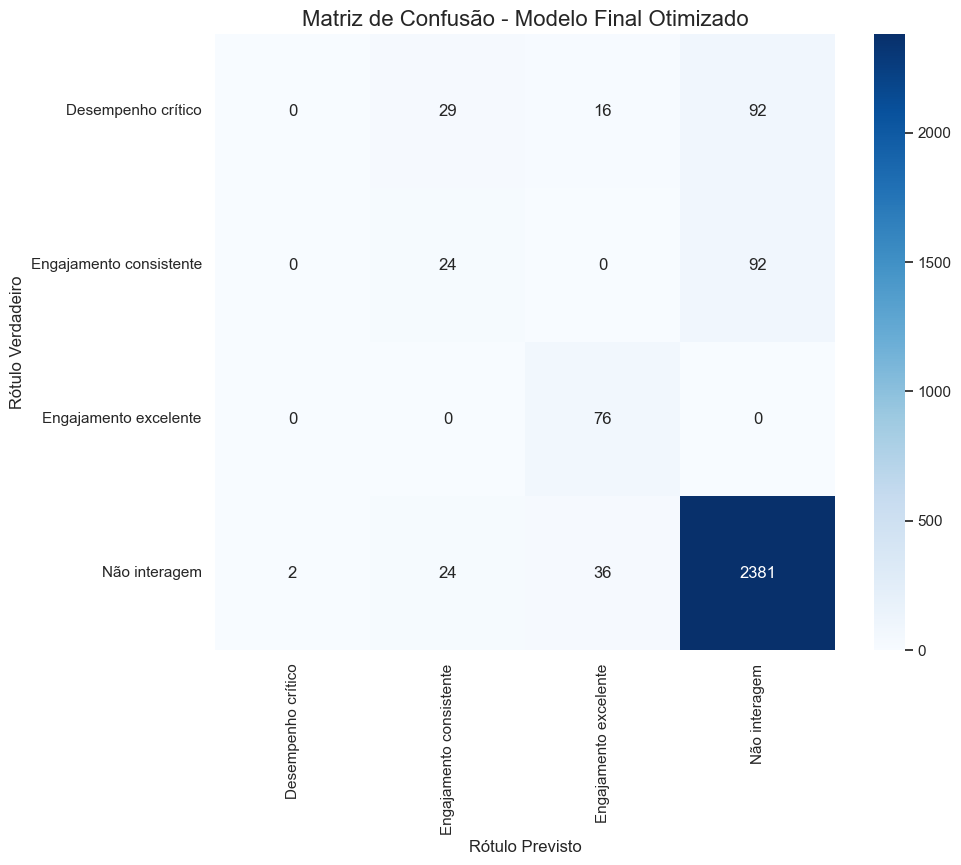

In [66]:
best_params_final = {
    'max_depth': 28,
    'max_features': 'sqrt',
    'min_samples_leaf': 3,
    'min_samples_split': 28,
    'n_estimators': 591
}

print("Usando os melhores parâmetros encontrados:", best_params_final)

# 2. Criar e treinar o modelo final com estes parâmetros
model_final = RandomForestClassifier(
    n_estimators=best_params_final['n_estimators'],
    max_depth=best_params_final['max_depth'],
    min_samples_leaf=best_params_final['min_samples_leaf'],
    min_samples_split=best_params_final['min_samples_split'],
    max_features=best_params_final['max_features'],
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Protegendo com if __name__ == '__main__' para compatibilidade com Windows
if __name__ == '__main__':
    print("\nTreinando o modelo final com os parâmetros otimizados...")
    model_final.fit(X_treino_safe, y_treino_encoded)
    print("Treinamento final concluído.")

    # 3. Fazer previsões no conjunto de teste
    y_pred_final = model_final.predict(X_teste_safe)

    # 4. Apresentar o Relatório de Classificação Definitivo
    print("\n=========== RELATÓRIO DE CLASSIFICAÇÃO (MODELO FINAL OTIMIZADO) ===========")
    report_final = classification_report(y_teste_encoded, y_pred_final, target_names=le.classes_)
    print(report_final)
    print("=" * 75)

    # 5. Apresentar a Matriz de Confusão Definitiva
    print("\n=========== MATRIZ DE CONFUSÃO (MODELO FINAL OTIMIZADO) ===========")
    cm_final = confusion_matrix(y_teste_encoded, y_pred_final)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Matriz de Confusão - Modelo Final Otimizado', fontsize=16)
    plt.ylabel('Rótulo Verdadeiro', fontsize=12)
    plt.xlabel('Rótulo Previsto', fontsize=12)
    plt.show()


In [67]:
def criar_features_de_razao(df):
    """
    Aplica a engenharia de features em um DataFrame para criar novas métricas de engajamento.
    """
    # Criar uma cópia para não alterar o DataFrame original
    df_eng = df.copy()
    
    # Usar um valor muito pequeno para evitar divisão por zero
    epsilon = 1e-6

    # 1. Feature de Interação Total
    features_originais = ['postsAmount', 'postRepliesAmount', 'helpRequestsAmount', 'helpRequestRepliesAmount']
    df_eng['interacao_total'] = df_eng[features_originais].sum(axis=1)

    # 2. Features de Razão (Ratios)
    df_eng['taxa_respostas_por_post'] = (df_eng['postRepliesAmount'] / 
                                       (df_eng['postsAmount'] + epsilon))
    
    df_eng['proporcao_ajuda_oferecida'] = (df_eng['helpRequestRepliesAmount'] / 
                                         (df_eng['helpRequestsAmount'] + epsilon))
                                         
    # 3. Features de Proporção em relação ao total
    total_com_epsilon = df_eng['interacao_total'] + epsilon
    df_eng['proporcao_posts'] = df_eng['postsAmount'] / total_com_epsilon
    df_eng['proporcao_pedidos_ajuda'] = df_eng['helpRequestsAmount'] / total_com_epsilon
    
    return df_eng

# Aplicar a função a todos os nossos conjuntos de dados
X_treino_eng = criar_features_de_razao(X_treino)
X_validacao_eng = criar_features_de_razao(X_validacao)
X_teste_eng = criar_features_de_razao(X_teste)

print("Novas features criadas com sucesso!")
print("\nDimensão do novo conjunto de treino:", X_treino_eng.shape)

print("\n--- Exemplo das 5 primeiras linhas do novo conjunto de treino ---")
print(X_treino_eng.head())

print("\n--- Estatísticas descritivas de algumas das novas features ---")
print(X_treino_eng[['interacao_total', 'taxa_respostas_por_post', 'proporcao_ajuda_oferecida']].describe())


Novas features criadas com sucesso!

Dimensão do novo conjunto de treino: (8313, 10)

--- Exemplo das 5 primeiras linhas do novo conjunto de treino ---
      postsAmount  postRepliesAmount  helpRequestsAmount  \
6617            0                  0                   0   
4747            0                  0                   0   
1470            0                  0                   0   
1098            0                  0                   0   
8399            0                  0                   0   

      helpRequestRepliesAmount  performance_rate  interacao_total  \
6617                         0              0.00                0   
4747                         0              0.25                0   
1470                         0              0.00                0   
1098                         0              0.00                0   
8399                         0              0.00                0   

      taxa_respostas_por_post  proporcao_ajuda_oferecida  proporcao_post

Treinando o modelo com as features de engenharia...
Treinamento concluído.

=========== RELATÓRIO DE CLASSIFICAÇÃO (COM ENGENHARIA DE FEATURES) ===========
                         precision    recall  f1-score   support

     Desempenho crítico       1.00      1.00      1.00       137
Engajamento consistente       1.00      1.00      1.00       116
  Engajamento excelente       0.99      1.00      0.99        76
          Não interagem       1.00      1.00      1.00      2443

               accuracy                           1.00      2772
              macro avg       1.00      1.00      1.00      2772
           weighted avg       1.00      1.00      1.00      2772


=========== MATRIZ DE CONFUSÃO (COM ENGENHARIA DE FEATURES) ===========


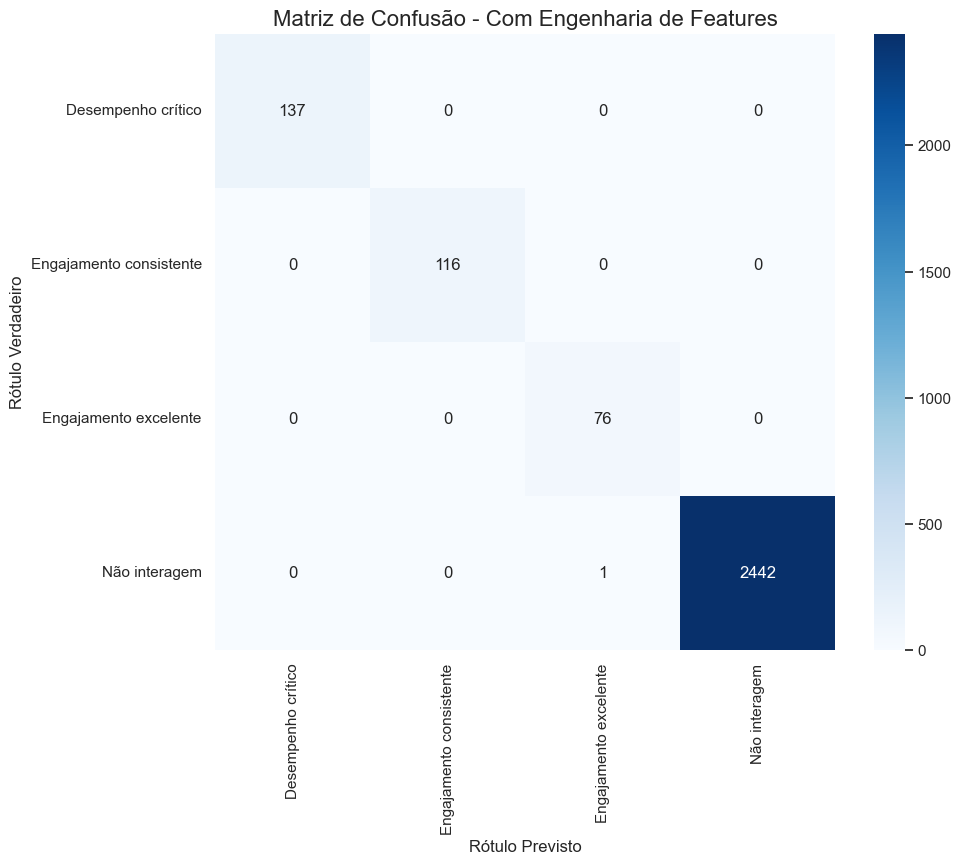

In [68]:
best_params_final = {
    'max_depth': 28,
    'max_features': 'sqrt',
    'min_samples_leaf': 3,
    'min_samples_split': 28,
    'n_estimators': 591
}

# 2. Criar e treinar o modelo com as NOVAS FEATURES
model_com_eng_features = RandomForestClassifier(
    **best_params_final,  # Desempacota o dicionário de melhores parâmetros
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Protegendo com if __name__ == '__main__' para compatibilidade com Windows
if __name__ == '__main__':
    print("Treinando o modelo com as features de engenharia...")
    model_com_eng_features.fit(X_treino_eng, y_treino_encoded)
    print("Treinamento concluído.")

    # 3. Fazer previsões no conjunto de teste com as novas features
    y_pred_eng = model_com_eng_features.predict(X_teste_eng)

    # 4. Apresentar o Relatório de Classificação
    print("\n=========== RELATÓRIO DE CLASSIFICAÇÃO (COM ENGENHARIA DE FEATURES) ===========")
    report_eng = classification_report(y_teste_encoded, y_pred_eng, target_names=le.classes_)
    print(report_eng)
    print("=" * 75)

    # 5. Apresentar a Matriz de Confusão
    print("\n=========== MATRIZ DE CONFUSÃO (COM ENGENHARIA DE FEATURES) ===========")
    cm_eng = confusion_matrix(y_teste_encoded, y_pred_eng)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_eng, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Matriz de Confusão - Com Engenharia de Features', fontsize=16)
    plt.ylabel('Rótulo Verdadeiro', fontsize=12)
    plt.xlabel('Rótulo Previsto', fontsize=12)
    plt.show()